# Cartoon Figures for JPP
Contains codes for generating cartoon (i.e. not based on data) pictures for JPP

## Import and Setup

In [1]:
# %% Imports
%load_ext autoreload
%autoreload 2

# numpy+scipy
import numpy as np
import scipy.ndimage

# matplotlib+tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

# GUDHI
import gudhi
import gudhi.representations

In [2]:
# %% matplotlib settings
font = {'size'   : 9 }

linescale = 0.6
mpl.rc('axes', unicode_minus=False, linewidth=linescale)
mpl.rc('lines', markersize=6.0*linescale, linewidth=1.5*linescale)

tick_major = {'size': 3.5*linescale, 'width': 0.8*linescale}
tick_minor = {'size': 2.0*linescale, 'width': 0.6*linescale}

mpl.rc('xtick.major', **tick_major)
mpl.rc('ytick.major', **tick_major)
mpl.rc('xtick.minor', **tick_minor)
mpl.rc('ytick.minor', **tick_minor)
mpl.rc('xtick', direction='in')
mpl.rc('ytick', direction='in')

mpl.rc('font', **font)

## GUDHI Cartoon Plot

In [13]:
# %% Generate the data

# Create a grid of points
x = np.linspace(-0.05, 1.05, 128)
y = np.linspace(0, 1.5, 192)
xgrid, ygrid = np.meshgrid(x, y)

# Properties of the blobs
rng = np.random.default_rng(42)  # For reproducibility
xblobs = [0.32, 0.17, 0.65, 0.23, 0.7, 0.25]
yblobs = np.linspace(0, 1.5, 2*len(xblobs)+2)[1:-1:2] + (0.1 * rng.random(len(xblobs)) - 0.05)
blobsizes = 0.07 + 0.005 * rng.random(len(xblobs))
#blobamplitudes = 0.15 + 0.0 * rng.random(len(xblobs))
blobamplitudes = blobsizes * 2

# Create the blobs
kappa = 1 # Background gradient
z = kappa*xgrid
for i in range(len(xblobs)):
    z += blobamplitudes[i] * np.exp(-((xgrid - xblobs[i])**2 + (ygrid - yblobs[i])**2) / blobsizes[i]**2)

z = kappa*xgrid
z += 0.1*(1+np.cos(20*ygrid + 0.5*np.cos(ygrid)))*np.exp(-90*(xgrid - 0.3 + 0.03*np.sin(4*ygrid))**2)
z += 0.125*(1+np.cos(10*ygrid + 0.5*np.cos(ygrid)))*np.exp(-40*(xgrid - 0.7 + 0.03*np.sin(4*ygrid))**2)


# Recenter the data
z = z - np.mean(z) + 0.5

noise = 0.05 * rng.standard_normal(z.shape)
noise = scipy.ndimage.gaussian_filter(noise, sigma=1.5)

z_noisy = z + noise

In [14]:
# %% Compute the persistence diagram

# Get a triangulation of the grid
xflat, yflat = xgrid.flatten(), ygrid.flatten()
zflat, z_noisy_flat = z.flatten(), z_noisy.flatten()

grid_tri = mpl.tri.Triangulation(xflat, yflat)

# Create a simplicial complex from the triangulation
st = gudhi.simplex_tree.SimplexTree()
st_noisy = gudhi.simplex_tree.SimplexTree()

# Insert vertices with filtration values into the tree
for i in range(len(xflat)):
    st.insert([i], zflat[i])
    st_noisy.insert([i], z_noisy_flat[i])

# Insert edges and triangles
for tri in grid_tri.triangles:
    # Extract and insert edges
    edges = [[tri[0], tri[1]], [tri[1], tri[2]], [tri[2], tri[0]]]
    for edge in edges:
        st.insert(edge, max(zflat[edge[0]], zflat[edge[1]]))
        st_noisy.insert(edge, max(z_noisy_flat[edge[0]], z_noisy_flat[edge[1]]))

    # Insert the triangle
    st.insert(tri, max(zflat[tri[0]], zflat[tri[1]], zflat[tri[2]]))
    st_noisy.insert(tri, max(z_noisy_flat[tri[0]], z_noisy_flat[tri[1]], z_noisy_flat[tri[2]]))


p = st.persistence()
p_noisy = st_noisy.persistence()


In [15]:
# %% Compute silhouettes

SH = gudhi.representations.Silhouette(resolution=128, sample_range=(0.0, 1.0), weight=lambda x: np.power(np.abs(x[1]-x[0]),2))

p1 = np.array(list(x[1] for x in p if x[0] == 1))
p1_noisy = np.array(list(x[1] for x in p_noisy if x[0] == 1))

sh = SH.fit_transform([p1])
sh_noisy = SH.fit_transform([p1_noisy])

In [437]:
p1[1,0]

0.43800737828039155

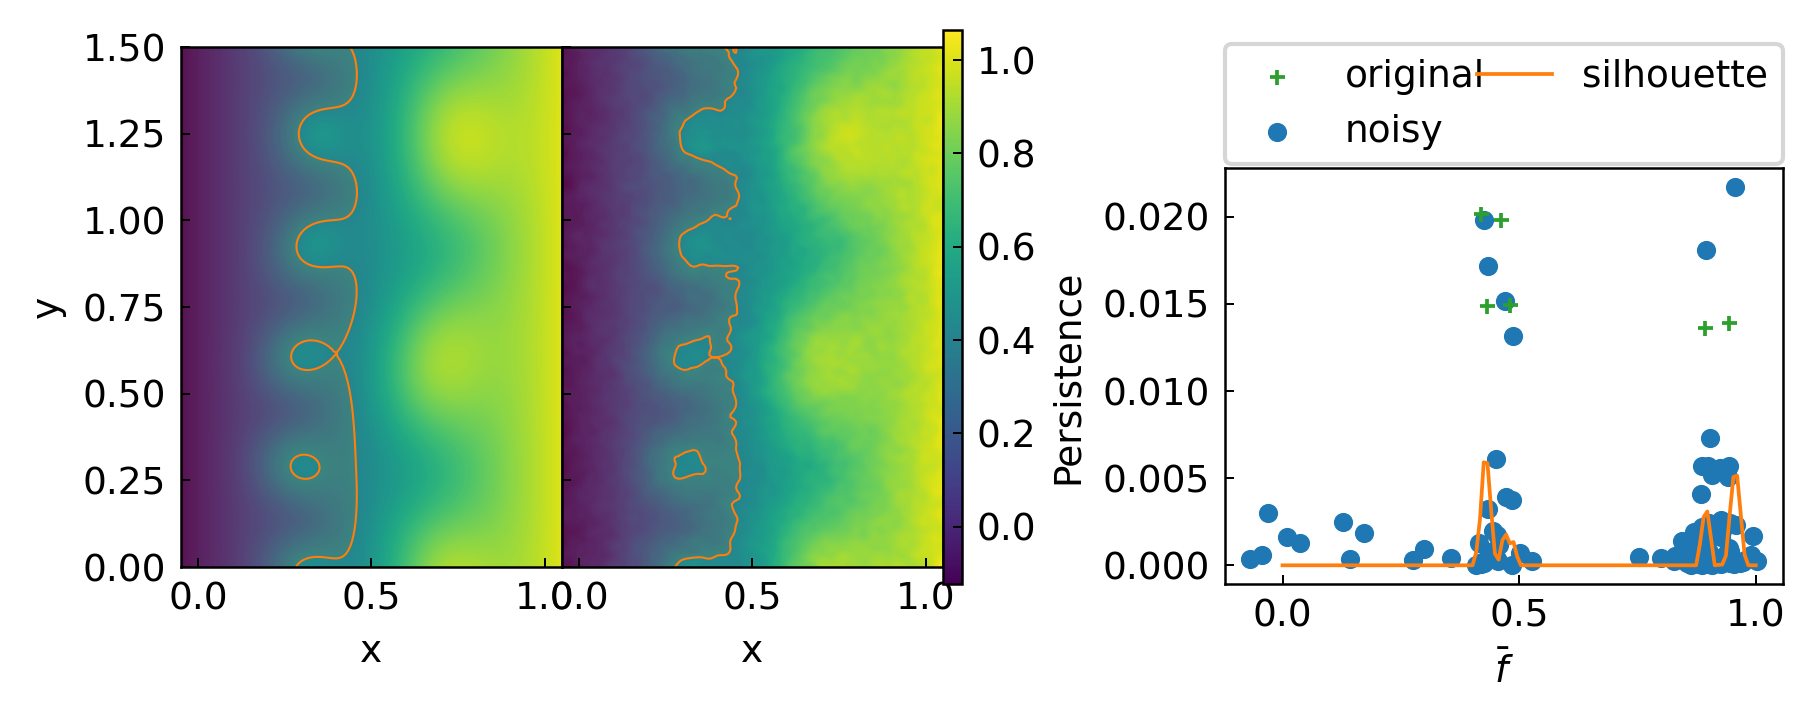

In [ ]:
from matplotlib.gridspec import GridSpec

# %% Plot the blobs along with the persistence diagrams
fig = plt.figure(figsize=(6.0, 2.4), dpi=300)

gs = GridSpec(1, 3, width_ratios=[1.4, 0.1, 1.0], wspace=1.08, figure=fig)
#gs_left = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.0, figure=fig)

# Create subfigures
subfig_left = fig.add_subfigure(gs[0])
subfig_right = fig.add_subfigure(gs[2])

# Left subfig: two columns, no horizontal spacing
axs_left = subfig_left.subplots(1, 3, width_ratios=[1, 1, 0.05], gridspec_kw={'wspace': 0.0})
# Right subfig: single axis
ax_right = subfig_right.subplots(gridspec_kw={'wspace': 1.08})

# You can now use axs_left[0], axs_left[1], and ax_right for plotting

vmin, vmax = np.min(z_noisy), np.max(z_noisy)

axs_left[0].imshow(z, extent=(-0.05, 1.05, 0, 1.5), origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs_left[0].contourf(xgrid, ygrid, z, levels=[-0.5, p1[3,0]], alpha=0.2, colors=['tab:orange'])
axs_left[0].contour(xgrid, ygrid, z, levels=[p1[3,0]], colors=['tab:orange'], linewidths=0.5)

pc = axs_left[1].imshow(z_noisy, extent=(-0.05, 1.05, 0, 1.5), origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs_left[1].contourf(xgrid, ygrid, z_noisy, levels=[-0.5, p1_noisy[3,0]], alpha=0.2, colors=['tab:orange'])
axs_left[1].contour(xgrid, ygrid, z_noisy, levels=[p1_noisy[3,0]], colors=['tab:orange'], linewidths=0.5)
axs_left[1].set_yticklabels([])  # Hide y-ticks for the noisy plot
fig.colorbar(pc, cax=axs_left[2], orientation='vertical')
#ax_dict['b'].set_yticklabels([])  # Hide y-ticks for the noisy plot
#axs[1].contour(xgrid, ygrid, z_noisy, levels=24, colors='k', linewidths=0.5, alpha=0.1)

ax_right.scatter((p1[:,0]+p1[:,1])/2, (p1[:,1]-p1[:,0])/2, marker='+', c='tab:green', label='original', zorder=1.1)
ax_right.scatter((p1_noisy[:,0]+p1_noisy[:,1])/2, (p1_noisy[:,1]-p1_noisy[:,0])/2, c='tab:blue', label='noisy')

ax_right.plot(np.linspace(0.0, 1.0, 128), sh_noisy[0], c='tab:orange', label='silhouette')

ax_right.set_xlabel(R'$\bar{f}$')
ax_right.set_ylabel(R'Persistence')

box = ax_right.get_position()
ax_right.set_position([box.x0, box.y0, box.width, box.height*0.75])
ax_right.legend(bbox_to_anchor=(0., 1.2, 1., .100), ncols=2, loc='upper right', mode="expand", borderaxespad=0.)

axs_left[0].set_xlabel('x')
axs_left[0].set_ylabel('y')
axs_left[1].set_xlabel('x')

#plt.tight_layout()
#plt.tight_layout()

plt.savefig('./outputs/jpp_figures/cartoon_tda.pdf', dpi=300)
plt.savefig('./outputs/jpp_figures/cartoon_tda.png', dpi=300)